<a href="https://colab.research.google.com/github/ovieimara/ITNPBD4/blob/master/TS_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook will help you generate synthetic datasets for Time Series. Instructions for setting parameters can be found at the end of the Notebook.
##The generated Time Series are plotted and saved in a .csv file. After generation the Notebook provides a decomposition of the Time series. It is up to you to find the correct set of parameters based on the instructions provided and through inspecting the code below.

In [84]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.0 MB/s eta 0:00:00


In [85]:
from os import sendfile
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Any
from statsmodels.tsa.seasonal import seasonal_decompose
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

class TimeSeriesABC(ABC):
  @abstractmethod
  def generate_time_series(self, *args, **kwargs) -> np.ndarray:
      pass


  @abstractmethod
  def generate_date_range(self, *args, **kwargs) -> pd.DatetimeIndex:
      pass

  @abstractmethod
  def generate_smooth_seasonality(self, *args, **kwargs) -> None:
      pass

  @abstractmethod
  def save_to_csv(self, *args, **kwargs) -> None:
      pass


  @abstractmethod
  def decompose_time_series(self, df, x_col, y_col, frequency='D'):
      pass

@dataclass()
class TimeSeriesGenerator(TimeSeriesABC):
  n_periods: int =100
  frequency: str = 'days'
  trend_slope: float = 0.3
  seasonal_period: str = 'monthly'
  seasonal_amplitude: float = 5
  noise_level: float = 0.5
  base_demand: int = 50  # Average daily demand


  def __post_init__ (self):
    #set seasonal_frequency
    self.seasonality()

    #Create a linear trend: A simple increasing trend from 0 to trend_slope * n_periods
    self.trend = np.linspace(0, self.trend_slope * self.n_periods, self.n_periods)  # Linear trend

    #Add minimal noise to the time series to make the residuals more realistic
    self.noise = np.random.normal(0, self.noise_level, self.n_periods)


  def generate_date_range(self, start_date: str ='2018-01-01') -> pd.DatetimeIndex :
    # Set frequency based on the input (days, months, or weeks)
    if self.frequency == 'days':
        freq = 'D'
        self.time_index = pd.date_range(start=start_date, periods=self.n_periods, freq=freq)
    elif self.frequency == 'months':
        freq = 'M'
        self.time_index = pd.date_range(start=start_date, periods=self.n_periods, freq=freq)
    elif self.frequency == 'weeks':
        freq = 'W'
        self.time_index = pd.date_range(start=start_date, periods=self.n_periods, freq=freq)
    else:
        raise ValueError("Frequency should be 'days', 'months', or 'weeks'.")

    return self.time_index

  def seasonality(self) -> None:

    if self.seasonal_period == 'monthly':
        # One full cycle per year (12 months)
        self.seasonal_frequency = 2 * np.pi / 12  # For monthly frequency
    elif self.seasonal_period == 'weekly':
        # One full cycle per year (52 weeks)
        self.seasonal_frequency = 2 * np.pi / 52  # For weekly frequency
    elif self.seasonal_period == 'annual':
        # One full cycle per year (365 days)
        self.seasonal_frequency = 2 * np.pi / 365  # For annual frequency
    else:
        raise ValueError("Seasonal period should be 'monthly', 'weekly', or 'annual'.")

  def generate_smooth_seasonality(self) -> None:
    # Smooth seasonal component (sine wave with the defined frequency)
    self.seasonal_component = self.seasonal_amplitude * np.sin(np.linspace(0, self.seasonal_frequency * self.n_periods, self.n_periods))

  def generate_time_series(self) -> np.ndarray:
    #Combine the trend, seasonality and noise to form a time series

     return  self.base_demand + self.trend + self.seasonal_component + self.noise

  def create_dataframe(self, x_col: str, y_col: str) -> pd.DataFrame:
    time_series = self.generate_time_series()
    # Prepare dataframe
    data = {x_col: self.time_index[:len(time_series)], y_col: np.clip(np.ceil(time_series), 0, 200)}
    return pd.DataFrame(data)

  # def column_int(self, df: pd.DataFrame, col_name: str) -> pd.DataFrame:
  #   df[col_name] = df[col_name].apply(lambda x: round(x))
  #   return df

  def plot_time_series(self, df: pd.DataFrame, x_col: str, y_col: str):
    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_col], df[y_col], label='Simulated Time Series For V.Ger Travel Car Rental Services')
    plt.title('Simulated Time Series Data with Trend and Seasonality')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.legend()
    plt.show()

  def save_to_csv(self, df, file_path) -> None:
    # Save the DataFrame to a CSV file
    df.to_csv('generated_time_series.csv', index=False)
    print("Time series data saved to 'generated_time_series.csv'.")


  def decompose_time_series(self, df,  x_col, y_col: str, frequency='D') -> Any:
    # Ensure the 'Time' column is in datetime format
    df[x_col] = pd.to_datetime(df[x_col])

    # Set 'Time' as the index
    # df.set_index(x_col, inplace=True)

    # Perform decomposition
    decomposition = seasonal_decompose(df[y_col], model='additive', period=365 if frequency == 'days' else 12)
    return decomposition


  def plot_decomposition(self, decomposition):
    # Plot the decomposed components
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.title('Observed')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='orange')
    plt.title('Trend')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal', color='green')
    plt.title('Seasonal')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', color='red')
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()


class dataFrameABC(ABC):
  @abstractmethod
  def generate_column(self, *args, **kwargs) -> np.ndarray:
      pass

  @abstractmethod
  def create_column_map(self, *args, **kwargs) -> None:
      pass

  @abstractmethod
  def create_column_apply(self, *args, **kwargs) -> None:
      pass

  @abstractmethod
  def create_column_data(self, *args, **kwargs) -> None:
      pass



@dataclass(slots=True)
class carRental():
  car_type: str = 'Compact'
  base_cost: int = 30
  brand: List[str] = ['Toyota', 'Honda', 'Ford']

  def brand(self) -> str:
    return self.brand

  def fleet(self, cars: Dict) -> List:
    return [carRental(car_type, cost, brand) for car_type, (cost, brand) in cars.items()]

def create_default_cars():
    return {'Compact': (30, ['Toyota', 'Honda', 'Ford']),
            'Sedan': (50, ['BMW', 'Mercedes', 'Audi']),
            'SUV': (70, ['Jeep', 'Ford', 'Chevrolet']),
            'Luxury': (100, ['Porsche', 'BMW', 'Mercedes'])}

@dataclass(slots=True)
class dataFrameGenerator(dataFrameABC):

  cars: Dict = field(default_factory=create_default_cars)

  def __post_init__(self):
    self.fleet = carRental().fleet(self.cars)

  def generate_column(self, n_periods: int = 100) -> np.ndarray:
    return np.random.choice([f.car_type for f in self.fleet], n_periods)

  def create_column_map(self, df: pd.DataFrame, input_col: str, output_col: str) -> None:
    df[output_col] = df[input_col].map({f.car_type: f.base_cost for f in self.fleet})

  def create_column_apply(self, df: pd.DataFrame, input_col: str, output_col: str) -> None:
    df[output_col] = df[input_col].apply(lambda x : np.random.choice(*[f.brand for f in self.fleet if f.car_type == x]))

  def create_column_data(self, df: pd.DataFrame, output_col: str, col_data: np.ndarray) -> None:
    df[output_col] = col_data


class carRentalABC(ABC):
  @abstractmethod
  def car_rental_dataframe(self, time_series_generator: TimeSeriesABC, start_date: str) -> pd.DataFrame:
      pass

  @abstractmethod
  def generate_car_rental_time_series(self, time_series_generator: TimeSeriesABC, df_generator: dataFrameABC, n_periods: int, start_date: str, col_data: str, col_map: str, col_apply: str) -> pd.DataFrame:
      pass

@dataclass(slots=True)
class carRentalData():
  time_series_generator: TimeSeriesABC
  df_generator: dataFrameABC
  n_periods: int
  start_date: str
  col_data: str
  col_map: str
  col_apply: str

class carRentalTimeSeries(carRentalABC):

  def car_rental_dataframe(self, time_series_generator: TimeSeriesABC, start_date: str, x_col, y_col: str) -> pd.DataFrame:
    self.time_index = time_series_generator.generate_date_range(start_date=start_date)
    time_series_generator.generate_smooth_seasonality()
    return time_series_generator.create_dataframe(x_col, y_col)

  def generate_car_rental_time_series(self, data: carRentalData, x_col, y_col: str)-> pd.DataFrame:

    df = self.car_rental_dataframe(data.time_series_generator, data.start_date, x_col, y_col)
    column_data = data.df_generator.generate_column(data.n_periods)
    data.df_generator.create_column_data(df, data.col_data, column_data)
    data.df_generator.create_column_map(df, data.col_data, data.col_map)
    data.df_generator.create_column_apply(df, data.col_data, data.col_apply)

    return df



<ipython-input-50-dfa3f7a7310d>:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.time_index = pd.date_range(start=start_date, periods=self.n_periods, freq=freq)


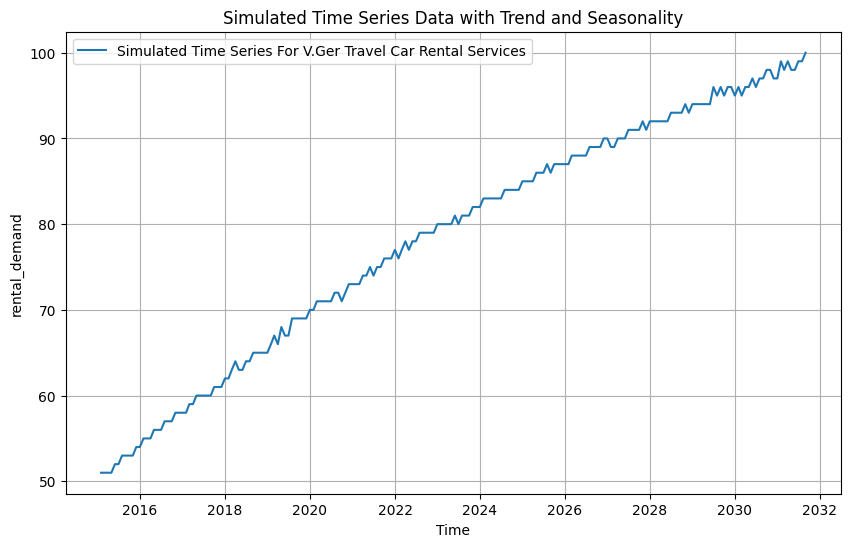

Time series data saved to 'generated_time_series.csv'.


In [51]:
n_periods=200
frequency='months'
trend_slope=0.25
seasonal_period='annual'
seasonal_amplitude=5
noise_level=0.4
base_demand = 50
start_date = '2015-01-01'
x_col, y_col = 'Time', 'rental_demand'
file_name = 'generated_time_series.csv'
col_data = 'car_type'
col_map = 'base_cost'
col_apply = 'brand'


time_series_generator = TimeSeriesGenerator(n_periods, frequency, trend_slope, seasonal_period, seasonal_amplitude, noise_level, base_demand)
car_rental = carRentalTimeSeries()
data_frame_generator = dataFrameGenerator()
car_rental_data = carRentalData(time_series_generator, data_frame_generator, n_periods, start_date, col_data, col_map, col_apply)

df = car_rental.generate_car_rental_time_series(car_rental_data, x_col, y_col)
time_series_generator.plot_time_series(df, x_col, y_col)
time_series_generator.save_to_csv(df, file_name)



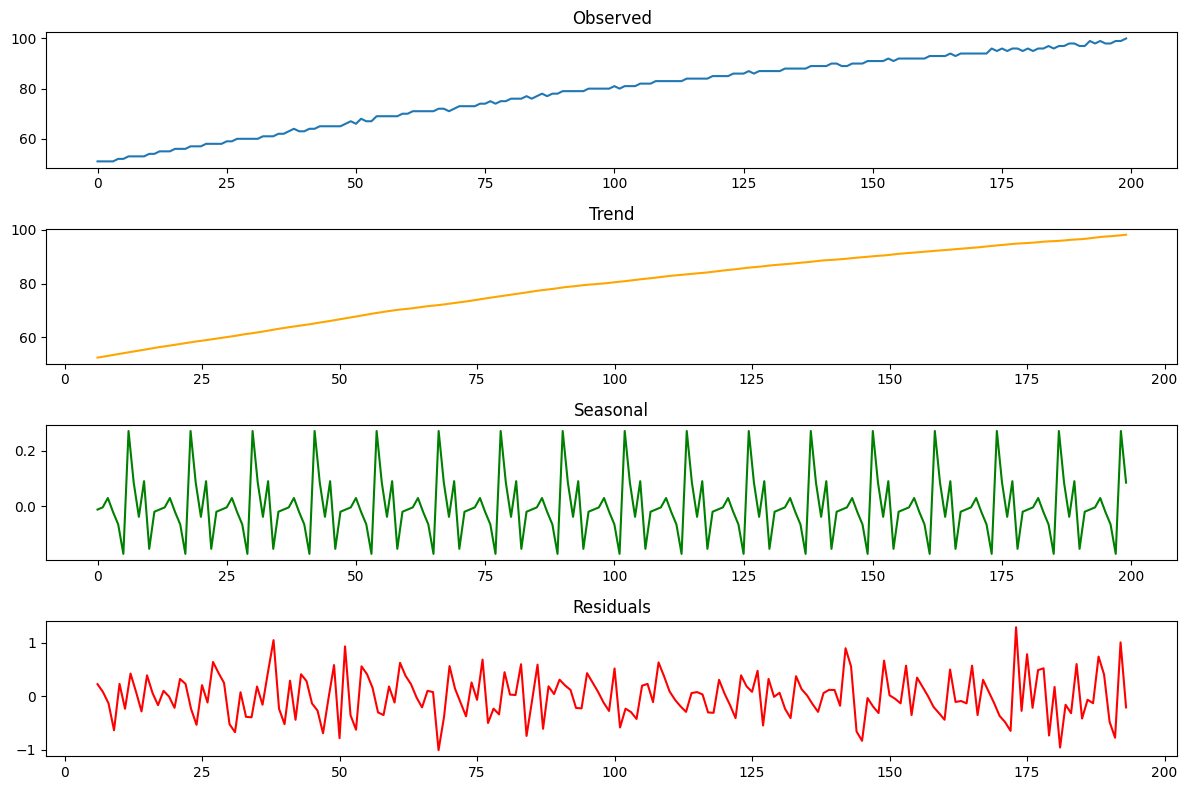

In [52]:
decomposition = time_series_generator.decompose_time_series(df, x_col, y_col)

time_series_generator.plot_decomposition(decomposition)

In [55]:
#test for stationarity
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

df.set_index(x_col, inplace=True)

def is_stationary(df:pd.DataFrame, y_col: str) -> bool:
  adfuller_result = adfuller(df[y_col])
  print(f'ADF Statistic: {adfuller_result[0]}')
  print(f'p-value: {adfuller_result[1]}')
  print(f'Critical Values: {adfuller_result[4]}')
  return "stationary" if adfuller_result[1] <= 0.05 else "non-stationary"

is_stationary(df, y_col)

ADF Statistic: -5.623362570397961
p-value: 1.1318149979694159e-06
Critical Values: {'1%': -3.4652439354133255, '5%': -2.8768752281673717, '10%': -2.574944653739612}


'stationary'

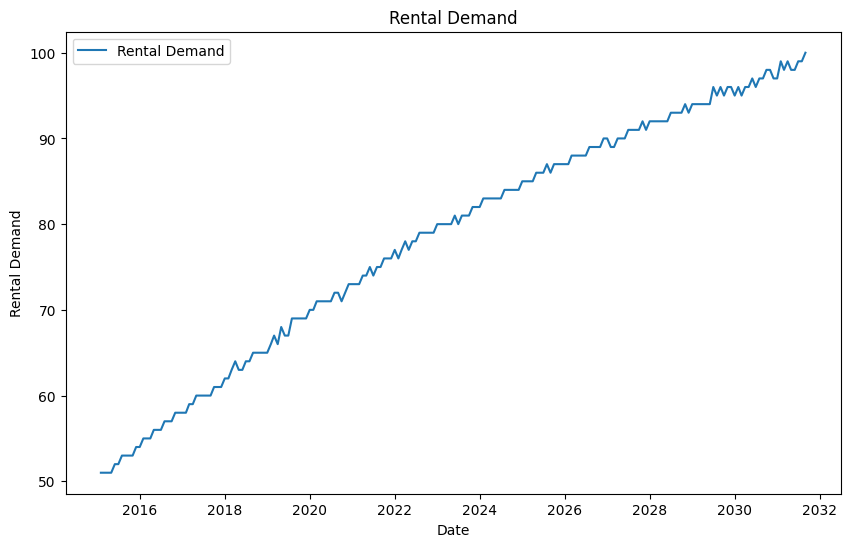

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(df[y_col], label="Rental Demand")
plt.title("Rental Demand")
plt.xlabel("Date")
plt.ylabel("Rental Demand")
plt.legend()
plt.show()


<Figure size 1200x600 with 0 Axes>

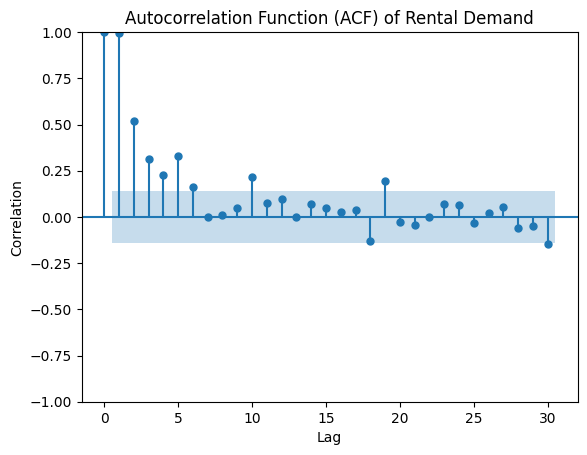

In [65]:
#plot pacf and acf to determine potential order of p

plt.figure(figsize=(12, 6))
plot_pacf(df[y_col], lags=30, method="ols")
plt.title("Autocorrelation Function (ACF) of Rental Demand")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()


We observe significant spikes (going beyond the confidence bands) at lags 1, 2, to 6 and 10. This suggests that there is a strong correlation between rental demand at the current time and its values 1, 2, 3, 4, 5, 6 and 10 periods ago.

Potential Seasonality: The spike at lag 10 strongly indicates a yearly seasonal pattern in rental demand. This is expected as rental demand typically fluctuates throughout the year due to factors like holidays, weather, and tourism seasons.

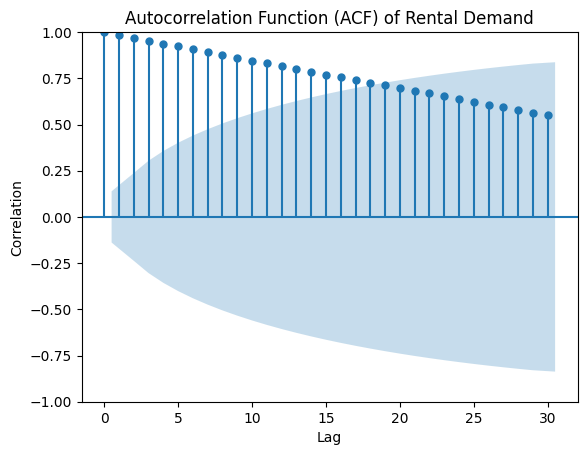

In [87]:
plot_acf(df[y_col], lags=30)
plt.title("Autocorrelation Function (ACF) of Rental Demand")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

In [124]:
# Fit the SARIMA model with automatic parameter selection
car_rental_sarima_model = pm.auto_arima(
    df[y_col],
    start_p=1, max_p=2,            # Non-seasonal AR terms
    start_q=1, max_q=2,            # Non-seasonal MA terms
    start_P=0, max_P=2,            # Seasonal AR terms
    start_Q=0, max_Q=2,            # Seasonal MA terms
    # d=1,                           # Differencing order
    # D=1,                           # Seasonal differencing order
    m=12,                          # Seasonal cycle length (12 for monthly data with yearly seasonality)
    seasonal=True,                 # Enable seasonality
    stepwise=True,                 # Enable stepwise search
    trace=True,                    # Output model selection details
    information_criterion='aic'    # Criterion for model selection
)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=347.024, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=613.993, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=493.844, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.61 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(1,0,0)[12]             : AIC=349.020, Time=0.31 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(0,0,1)[12]             : AIC=349.021, Time=0.31 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(1,0,1)[12]             : AIC=350.025, Time=0.90 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,0)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=491.871, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=330.794, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,1)(1,0,0)[12]             : AIC=332.705, Time=0.30 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,1)(0,0,1)[12]             : AIC=332.719, Time=0.30 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,1)(1,0,1)[12]             : AIC=333.785, Time=0.72 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=435.984, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,2)(0,0,0)[12]             : AIC=300.480, Time=0.53 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,2)(1,0,0)[12]             : AIC=302.477, Time=1.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,2)(0,0,1)[12]             : AIC=302.477, Time=4.59 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,2)(1,0,1)[12]             : AIC=inf, Time=1.58 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=299.572, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,2)(1,0,0)[12]             : AIC=301.530, Time=0.66 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,2)(0,0,1)[12]             : AIC=301.536, Time=0.52 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,2)(1,0,1)[12]             : AIC=301.905, Time=0.93 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=297.579, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,2)(1,0,0)[12]             : AIC=299.536, Time=0.37 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,2)(0,0,1)[12]             : AIC=299.542, Time=0.42 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,2)(1,0,1)[12]             : AIC=299.917, Time=0.84 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,2)(0,0,0)[12] intercept   : AIC=294.135, Time=0.46 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,2)(1,0,0)[12] intercept   : AIC=296.111, Time=1.36 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,2)(0,0,1)[12] intercept   : AIC=296.105, Time=1.32 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,2)(1,0,1)[12] intercept   : AIC=298.135, Time=3.69 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=inf, Time=1.58 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,2)(0,0,0)[12] intercept   : AIC=296.043, Time=0.70 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.44 sec

Best model:  ARIMA(0,2,2)(0,0,0)[12] intercept
Total fit time: 25.878 seconds


In [125]:
car_rental_sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -143.068
Date:                Sun, 22 Dec 2024   AIC                            294.135
Time:                        22:50:23   BIC                            307.288
Sample:                    01-31-2015   HQIC                           299.459
                         - 08-31-2031                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0009      0.000     -3.750      0.000      -0.001      -0.000
ma.L1         -1.8721      0.042    -44.577      0.000      -1.954      -1.790
ma.L2          0.8787      0.042     20.861      0.000       0.796       0.961
sigma2         0.2386      0.023     10.233      0.000       0.193       0.284
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 2.51
Prob(Q):                              0.76   Prob(JB):                         0.29
Heteroskedasticity (H):               1.31   Skew:                             0.25
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Figure size 1000x600 with 0 Axes>

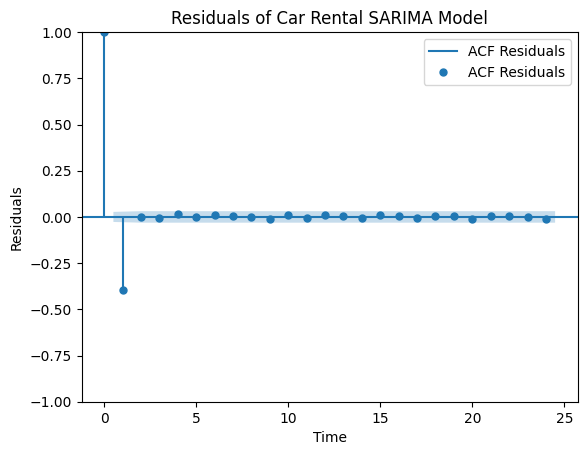

In [130]:
residual = car_rental_sarima_model.arima_res_.resid

plt.figure(figsize=(10, 6))
plot_acf(residual, label="ACF Residuals", alpha=0.7)
plt.title("Residuals of Car Rental SARIMA Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

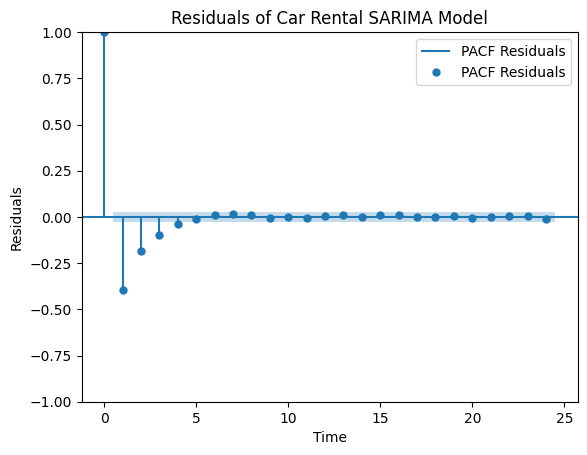

In [131]:
plt.figure(figsize=(10, 6))
plot_pacf(residual, label="PACF Residuals", alpha=0.7)
plt.title("Residuals of Car Rental SARIMA Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.show()

1. n_periods (Number of Time Steps)

    Description: Specifies how many data points you want to generate.
    Usage: Affects the length of the time series.
    Example Values:
        n_periods=100 for a short time series.
        n_periods=500 for a longer time series.
    Default: 100.

2. frequency (Time Frequency)

    Description: Defines the time intervals of the series.
    Options:
        'days': Daily time intervals.
        'weeks': Weekly time intervals.
        'months': Monthly time intervals.
    Usage: Determines the time range of the time series.
    Example Values:
        frequency='days' for daily observations.
        frequency='weeks' for weekly data.
        frequency='months' for monthly data.
    Default: 'days'.

3. trend_slope (Linear Trend Slope)

    Description: Controls how quickly the trend increases over time.
    Usage: Affects the magnitude of the overall increase in the series.
    Example Values:
        trend_slope=0.1: A slow-growing trend.
        trend_slope=0.5: A faster-growing trend.
        trend_slope=0: No trend (flat).
    Default: 0.3.

4. seasonal_period (Seasonal Pattern)

    Description: Specifies the type of seasonality to include in the series.
    Options:
        'monthly': Seasonal variations occur every 12 periods (e.g., months in a year).
        'weekly': Seasonal variations occur every 52 periods (e.g., weeks in a year).
        'annual': Seasonal variations occur every 365 periods (e.g., days in a year).
    Usage: Adjust this to reflect real-world seasonality based on the data's frequency.
    Example Values:
        seasonal_period='monthly' for sales data.
        seasonal_period='weekly' for weekly activity patterns.
        seasonal_period='annual' for long-term trends.
    Default: 'monthly'.

5. seasonal_amplitude (Strength of Seasonality)

    Description: Controls the magnitude of the seasonal fluctuations.
    Usage: Sets the "height" of seasonal oscillations relative to the trend.
    Example Values:
        seasonal_amplitude=2: Subtle seasonal variation.
        seasonal_amplitude=10: Strong seasonal variation.
    Default: 5.

6. noise_level (Random Variation)

    Description: Adds random noise to simulate natural variability in the data.
    Usage: Higher values create noisier data, while lower values make it smoother.
    Example Values:
        noise_level=0: No noise.
        noise_level=0.5: Moderate noise.
        noise_level=2: High noise.
    Default: 0.5.

Tips for Setting Parameters:

    Match Seasonality to Frequency: Ensure that the seasonal_period makes sense for the chosen frequency.
        Example: For frequency='months', use seasonal_period='monthly' for realistic results.
    Control Noise for Clarity: Use noise_level=0 for clean series or increase it slightly (e.g., 0.2) to simulate real-world randomness.
    Trend Dominance: Ensure the trend_slope is much larger than seasonal_amplitude if you want the trend to dominate over seasonality.